In [ ]:
# Библиотеки для упражненй
# Нужно установить недостающие библиотеки
import math, random
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from IPython.display import display

# PSLG overlaying

## Терминология

* ППЛГ $-$ плоский прямолинейный граф. 
* РСДС $-$ ребренный список с двойными связями.
* ППЛГ удобно хранить с помощью РСДС.

* ППЛГ $O(S_1,S_2)$ $-$ пересечение двух ППЛГ $S_1$ и $S_2$, такой, что грань $f$ принадлежит $O(S_1,S_2)$ тогда и только тогда, когда существуют грани $f_1$ из $S_1$ и $f_2$ из $S_2$, что $f$ $-$ максимальное связанное подмножество пересечения $f_1$ и $f_2$.

<img src="images/пересечение пплг.png" />


## Задача
Заданы многоугольники, необходимо найти их пересечение.

## Задача на самом деле
Данная задача сводится к задачи о пересечении двух РСДС, которую и будем решать.

## Задача, ну вот теперь уж точно
Необходимо построить РСДС для $O(S_1,S_2)$ по РСДС $S_1$ и $S_2$. 


## Алгоритм

Алгоритм работает в три этапа:
   *  Нахождение информации о ребрах $O(S_1,S_2)$
   *  Построение граней $O(S_1,S_2)$
   *  Связать грани из $O(S_1,S_2)$ с гранями из $S_1$ и $S_2$

### Нахождение информации о ребрах $O(S_1,S_2)$

#### Заметающая прямая

Алгоритм "заметающей прямой" решает задачу о пересечении множества отрезков и работает за $O((n+I)*log(n))$, где $I$ $-$ количество пересечений и использует $O(n)$ памяти. Главная идея этого алгоритма в том, что есть вертикальная прямая, она движется вправо и следит за событиями: 
    * прямая пересекла правый конец отрезка (конец отрезка)
    * прямая пересекла левый конец отрезка (начало отрезка)
    * прямая пересекла точку пересечения пары отрезков

<img src="images/заметающая прямая.png" />

Нахождение пересечений ребер $S_1$ и $S_2$ базируется на алгоритме "заметающей прямой" с небольшими изменениями:

#### Необходимые структуры данных

* очередь событий $Q$
* статус $T$, который может быть сбалансированным бинарным деревом поиска, хранящим сегменты пересечений заметающей прямой, упорядоченных снизу вверх

#### Обработка ребер

Будем придерживаться инварианта, что в любой момент времени, события на заметающей прямой, которые мы уже обработали, пересчитаны корректно для $O(S_1,S_2)$

* Скопируем РСДС $S_1$ и $S_2$ в новый РСДС. Мы получили новый РСДС, без правильных вершинно-ребренных связей. Наша задача получить из текущего РСДС корректный РСДС.
* На новом РСДС запускаем алгоритм заметающей прямой на множестве ребер, являющимся объединением ребер из $S_1$ и $S_2$. 
* Если на заметающей прямой мы обрабатываем событие, представляющее собой вершину, в которую входят ребра только одного РСДС, то эту вершину можно переиспользовать, и мы можем перейти к следующему событию ничего не меняя.
* Иначе надо изменить РСДС. Пусть у нас есть два ребра $e_1$, $e_2$ и вершина $v$ $-$ событие на заметающей прямой. 
     * Возможны следующие случаи:
          1. Вершина ребра $e_2$ проходит через ребро $e_1$, разбивая его на два новых ребра
          
          2. Ребро $e_1$ пересекает ребро $e_2$ и образуется 4 новых ребра
          
          3. Ребра $e_1$ и $e_2$ пересекаются в вершине
          
          4. Вершина ребра $e_1$ проходит через ребро $e_2$, разбивая его на 2 новых ребра
          
          5. Ребра $e_1$ и $e_2$ имеют общий отрезок и образуют новое ребро
          
          
     * При этом необходимо учесть, что в одной точке может пересекаться более двух ребер.
       Такой случай рассмотривается аналогично, просто для всех ребер, содержащих данную
       вершину необходимо обновить структуру.

<img src="images/варианты пересечения ребер.png" />

Рассмотрим алгоритм разбора для случая $4$, остальные случаи обрабатываются аналогично.
* Получим новые полуребра

    * Пусть ребро $e$ из $S_1$ проходит через вершину $v$ из $S_2$, разбивая его на два новых ребра. Ребро $e$ заменяется двумя ребрами $e'$ и $e''$ . Два полуребра, соотвествующие ребру $e$, заменяются на 4 полуребра $h_1, h_2, h_3, h_4$. 
    
* Разберемся с $Twin()$
    * Обрабатываем обратные ребра $-$ $Twin()$ $-$ (близнецы). Устанавливаем ссылки на ребра $h_1, h_2, h_3, h_4$ и обновляем ссылки на "твины" для $h_1$ и $h_4$ $-$ полуребра будут $h_5$ и $h_6$, так же не забываем обновить ссылки на "твины" для $h_5$ и $h_6$ ($h_1$ и $h_4$ соответственно).
    <img src="images/создание новых полуребер.png" />
    
* Разберемся с $Prev()$ и $Next()$
    * Для ребер, заканчивающихся и начинающихся на концах ребра $e$, легко определить $Next()$ и $Prev()$ соответственно, скопировав их для ребра $e$. 
    <img src="images/ссылки новых полуребер1.png" />
    * Теперь нужно установить значения $Prev()$ и $Next()$ для ребер, заканчивающихся в вершине $v$. Определим, между какими ребрами должны находться ребра $e'$ и $e''$ в порядке циклического обхода вокруг вершины $v$. Поймем, что полуребро $e'$, которое заканчивается в точке $v$, должно быть связано с первым полуребром, видимым из $v$ при обходе по часовой стрелке, установим для него $Next()$. Обратное ему полуребро свяжем с первым ребром, закакнчивающимся в $v$ при обходе против часовой стрелки, установив тем самым $Next()$.
    * Рассмотрим полуребро $h_3$ и свяжем его с первым полуребром, видимым из $e'$ при обходе по часовой стрелке и исходящем из $v$. Полуребро $h_4$ свяжем с первым полуребром, идущим в $v$, при обходе против часовой стрелки. Аналогично надо сделать для ребра $e''$.
    <img src="images/ссылки новых полуребер2.png" />
* Применим вышеописанный алгоритм для всех ребер, инцедентных данной вершине.
    


#### В итоге, чтобы получить информацию о ребрах, необходимо:

* Скопировать ребра $S_1$ в список ребер $S_2$
* Запустить алгоритм заметающей прямой, во время которого надо создать новые ребренные связи

### Время работы

Разбор каждого случая происходит за $O(p)$ где $p$ - степень вершины, так как создание и обновление ссылок на полуребра работает $O(1)$ для каждого ребра, количество которых равно степени вершины - $p$. Значит, обновление РСДС не увеличивает время работы алгоритма заметающей прямой. Из чего можно сделать вывод, что нахождение информации о вершинах и итогового РСДС работает за $O(n * \log(n)+k * \log(k))$, где $k$ - количество точек пересечений, $n$ - суммарная сложность $S_1$ и $S_2$.

### Память

В каждый момент времени на заметающей прямой мы храним $O(n)$ событий, где $n$ - суммарная сложность $S_1$ и $S_2$, так как на вертикальной прямой не может быть больше чем $n$ точек пересечений, начал и концов отрезков. На каждое событие нам нужно $O(???)$, Итого суммарная память - $O(???)$

In [1]:
import solutions 

### Упражнениe 1

* Задача:
    * написать функцию, которая обрабатывает событие пересечения двух полуребер, корректно перестаивая струтуру $half-edge$ (см. ниже) для случая $2$
    * упростим задачу: будем считать, что через точку пересечения заданных ребер проходят только эти ребра, и не возникает новых пересечений на концах заданных ребер.
* Формат входных данных:
    * $he1$, $he2$ $-$ полуребра, которые необходимо пересечь, соответственно
    * $point$ $-$ точка пересечения
    * вершина задается следующим образом: $[x,y]$, где $x$ и $y$ $-$ координаты вершины
* Формат выходных данных:
    * массив получившихся полуребер в порядке обхода, начиная с вершины начала ребра $he1$
    

In [2]:
class HalfEdge:
    __slots__ = ("origin", "twin", "next", "prev", "face")

    def __init__(self, origin, twin=None, next=None, prev=None, face=None):
        self.origin = origin
        self.twin = twin
        self.next = next
        self.prev = prev
        self.face = face

    # origin и twin задаются с помощью ребра Edge
class Edge:
    def __init(self, a, b):
        self.a = a # точка начала ребра
        self.b = b # точка конца ребра
 
    # пример создание полуребра
# he1 = HalfEdge(Edge(Point(1, 2), Point(3, 2)))

In [3]:
def event(he1, he2, point):
    # Insert your code here...
    return []
event = solutions.event    

Проверим корректность решения:

* $solutions.test$_$event$ тестирует функцию $event$

In [4]:
solutions.test_event(event)

All tests passed




## Построение граней $O(S_1,S_2)$

В первой части мы научились создавать связи между ребрами и вершинами $O(S_1,S_2)$, но это еще не корректный РСДС. 
Нам необходимо создать грани и связать их с ребрами:

1) для каждой грани $f$ просчитать $InnerComponents(f)$ и $OuterComponent(f)$.
  *  $InnerComponents(f)$ $-$ список указателей на полуребра внутренних границ.
  *  $OuterComponent(f)$ $-$ указатель на полуребро внешней границы $f$
    
2) установить $IncidentFace()$ для каждого полуребра

Первый вопрос, который возникает $-$ сколько будет граней у $O(S_1,S_2)$? Их будет количество циклов плюс один, так как каждый цикл будет создавать одну грань и еще одна $-$ бесконечная грань для удобства, будем считать, что все грани которые не имеют внешней компоненты теперь станут внутренними для этой фиктивной бесконечной грани.

Из первой части алгоритма можно легко найти все циклы. Теперь возникает вопрос $-$ как понять, что цикл являются границей грани или дырки. Рассмотрим самую левую вершину ($v$) цикла. Определим угол внутри грани между полуребрами, инцидентными вершине $v$. Если угол меньше 180 градусов, тогда цикл $-$ граница грани, иначе $-$ граница дырки. Это свойство выполняется только для самой левой вершины цикла, так как грань будет лежать по правую сторону относительно вертикально прямой, проходящей через вышеупомянутую вершину $v$, для остальных может не выполняться. 
<img src="images/углы.png" />

Теперь остается последний вопрос $-$ какие границы принадлежат одной грани? Для этого можно построить граф $G$. Для каждого цикла, который задает границу грани и границу дырки будет вершина в графе $G$. Также есть еще одна вершина в графе $G$ $-$ граница бесконечной грани. Рассмотрю любые две вершины $e_i$ и $e_j$ из графа $G$. 

Возможны следующие случаи:

* $e_i$ $-$ цикл, который задает границу дырки, а $e_j$ $-$ ближайший слева цикл по отношению к самой левой вершине цикла $e_i$, задающий границу грани. Тогда $e_i$ является внутренней гранью для $e_j$
    
*  $e_i$ $-$ цикл, который задает границу дырки, а $e_j$ $-$ ближайший слева цикл по отношению к самой левой вершине цикла $e_i$, задающий границу дырки. Тогда $e_i$ является внутренней гранью внешней грани $e_j$
    
* для цикла $e_i$ нетближайшег слева цикла. Тогда он является внутренней гранью для фиктивной бесконечной грани.

Между $e_i$ и $e_j$ вершинами мы создадим ребро, если $e_i$ $-$ цикл, который задает границу дырки, а $e_j$ $-$ ближайший слева цикл по отношению к самой левой вершине цикла $e_i$, задающий границу грани. Если для какого то цикла $e_q$ нет ни какого цикла слева, то тогда его соединяем в графе $G$ с бесконечной гранью. Для примера, разберем картинку:
<img src="images/граф.png" />
Граф, изображенный на картинке соответствует изображенной фигуре. На графе двойным кружком изображены циклы, задающие границы граней, а одинарным $-$ задающие границы дырок. Очевидно, что циклы $e_3$ и $e_6$ в той же грани, что и $e_2$. Так же очевидно, что $e_1$ в бесконечной грани. 

По картинке заметим утверждение:

**Теорема** *Каждая компонента связности графа $G$ соответсвует множеству циклов инцидентных одной гране.*
<br>$\triangleright$<br>
<div style="padding-left:40px">
Рассмотрим цикл $C$, который является границей дырки грани $f$. Так как грань $f$ лежит левее самой левой вершины цикла $C$, то $C$ должно быть связан с другим циклом грани $f$. 

Для завершнения доказательства нам надо показать, что каждый цикл, ограничивающий дырку в грани $f$, в одной компоненте связности с границей грани $f$. Пусть существует цикл, который ограничивает дырку в грани $f$, но не лежащий в одной компоненте связности с границей грани $f$. Рассмотрим самый левый цикл $C$, который удовлетворяет предположению. Тогда его самая левая вершина в цикле $C$ тоже является самой левой. По построению сущетсвует отрезок между циклом $C$ и другим циклом $C'$, который лежит левее самой левой вершины цикла $C$. Значит $C$ и $C'$ лежат в одной компоненте связности. Значит $C'$ не граница грани $f$ и тоже не лежит в одной компоненте связности с границей $f$. Получается $C$ не самый левый цикл, который удовлетворяет преположению. Получили противоречие.
</div>
$\triangleleft$

Данная теорема показывает, что мы можем создать для каждой компоненты связности по грани. Потом мы можем задать $IncidentFace$ для каждого полуребра из границы грани $f$. Так же мы можем создать список $InnerComponents(f)$ и $OuterComponent(f)$.

Нам осталось разобраться, как же построить граф $G$. Вспомним, что в алгоритме заметающей прямой мы искали ближайший слева отрезок от вершины. Давайте запустим заново этот алгоритм и получим информацию только для самых левых точек всех циклов. Для оптимизации давайте хранить в каждом полуребре ссылку на вершину графа $G$, содержащую данное полуребро. В алгоритме заметающей прямой, если $e$ $-$ полуребро, ближашее слева к вершине $v$, тогда мы добавим ребро в графе $G$ между двумя вершинами, соответсвующие циклу, в котором есть полуребро $e$ и в котором $v$ $-$ самая левая вершина.
<img src="images/построение графа.png" />


В итоге, чтобы получить информацию о гранях нужно:
* Найти все циклы в структуре, полученной из первой части алгоритма.
* Для каждого цикла определить чем он является: границей дырки или границей грани.
* Для каждого цикла создать вершину графа $G$.
* Для каждого полуребра создать ссылку на вершину графа $G$, содержащую данное полуребро.
* Запустить алгоритм заметающей прямой и построить ребра граней $G$.
* Найти все компоненты связности графа $G$ и по ним построить грани и ссылки связанные с гранями.

### Время работы

Создание вершин графа $G$, нахождение циклов и определение их типа занимает линейное время. Построение граней по компонентам связности $G$ тоже занимает линейное время. Так же заметим, что в алгоритме заметающей прямой не появляются новые отрезки, а значит он будет работать за линейное время. В итоге построение граней $O(S_1,S_2)$ работает за $O(n+k)$, где $n$ - , $k$ - .

In [5]:
import solutions 

### Упражнение 2

* Задача:
    * написать функцию, которая проверяет, что одна грань находится внутри другой 
* Формат входных данных:
    * $g1$, $g2$ $-$ первая и вторая грани соответственно
    * грань задается как список точек в порядке обхода против часовой стрелки
* Формат выходных данных:
    * $True$ $-$ $g1$ внутри $g2$
    * $False$ $-$ иначе

In [6]:
def inside(g1, g2):
    # Insert your code here...
    return []
inside = solutions.inside    

Проверим корректность решения:

* $solutions.test$_$inside$ тестирует функцию $inside$
* $solutions.show$_$test$ визуализирует статический тест, поданный на вход

In [7]:
solutions.test_inside(inside)

passed 2 tests
passed 4 tests
passed 6 tests
passed 8 tests
All tests passed


result=POLYGON ((3 2, 6 3, 7 2, 3 2))


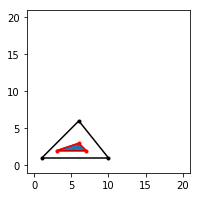

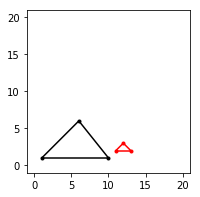

In [8]:
p1=[[1, 1], [6, 6], [10, 1]]
p2=[[3, 2], [6, 3], [7, 2]]
p3=[[11, 2], [12, 3], [13, 2]]

solutions.show_test(p1,p2)
solutions.show_test(p1,p3)

## Связка граней из $O(S_1,S_2)$ с гранями из $S_1$ и $S_2$

Для того, чтобы найти исходные грани для грани $f$ из $O(S_1,S_2)$, рассмотрю вершину $v$ грани $f$. 

Если $v$ — пересечение ребера $e_1$ из $S_1$ с ребром $e_2$ из $S_2$, тогда мы можем найти грани из $S_1$ и $S_2$, которые содержат грань $f$ очень просто. Для этого нам надо вызвать функцию $IncidentFace()$ в полуребрах, соответсвующие ребрам $e_1$ и $e_2$. 

Если $v$ — не пересечение, а вершина из $S_1$ (для $S_2$ аналогично), то мы легко можем найти грань из $S_1$, в которой содержится грань $f$. Для того, чтобы найти грань из $S_2$, содержащую $f$, нам надо проделать немного работы. Другими словами, нам надо знать для каждой вершины из $S_1$ в какой грани из $S_2$ она находится. Тогда мы сможем корректно пометить каждую грань из $O(S_1,S_2)$ гранями из $S_1$ и $S_2$. Чтобы решить эту задачу можно воспользоваться алгоритмом локализации в PSLG или алгоритмом заметающей прямой. 

В итоге, чтобы пометить каждую грань из $O(S_1,S_2)$ гранями из $S_1$ и $S_2$ надо:
* Связать каждую вершину из $S_1$ c гранями из $S_2$
* Связать каждую вершину из $S_2$ с гранями из $S_2$
* Рассмотреть любую вершину из каждой грани из $O(S_1,S_2)$. 

### Время работы
Для связки каждой вершины из $S_1$ c гранями из $S_2$ требуется $O(n*\log n +k*\log n)$ времени, аналогично надо связать каждую вершину из $S_2$  с гранями из $S_1$, что потребует $O(n*\log n+k*\log n)$ времени. Значит, чтобы пометить каждую грань из $O(S_1,S_2)$ гранями из $S_1$ и $S_2$ нам потребуется $O(n*\log n+k*\log n)$ времени. 


## Итог...

# Краткое описание алгоритма
На вход получаем два РСДС $S_1$ и $S_2$.
Возвращаем $O(S_1,S_2)$ в виде РСДС.
* Скопировать ребра $S_1$ в список ребер $S_2$ и получаем новый реберный список.
* Запустить алгоритм заметающей прямой, во время которого надо создать новые ребренные связи.
* В результате предыдущего шага, получаем $D$ - реберно список $O(S_1,S_2)$
* Найти все циклы в реберном списке $D$
* Для каждого цикла определить чем он является: границей дырки или границей грани.
* Для каждого цикла создать вершину графа $G$.
* Для каждого полуребра создать ссылку на вершину графа $G$, содержащую данное полуребро.
* Запустить алгоритм заметающей прямой и построить ребра граней $G$.
* Найти все компоненты связности графа $G$ и по ним построить грани и ссылки связанные с гранями.
* Пометить каждую грань из $O(S_1,S_2)$ гранями из $S_1$ и $S_2$.

# Время работы
Пусть $n_1$ - сложность $S_1$, а $n_2$ - сложность $S_2$. Пусть $n=n_1+n_2$. Тогда по доказанному ранее первая часть алгоритма работает за $O(n * \log(n)+k * \log(n))$. По доказанному ранее вторая часть алгоритма работает за $O(n+k)$. Значит весь алгоритм работает за $O(n * \log(n)+k * \log(n))$.

In [9]:
import solutions

## Упражнение 3

* Задача:
    * написать функцию, которая пересекает многоугольники
* Формат входных данных:
    * $points1$ $-$ массив с вершинами первого многоугольника.
    * $points2$ $-$ массив с вершинами второго многоугольника.
    * вершина задается следующим образом: $[x,y]$, где $x$ и $y$ $-$ координаты вершины
* Формат выходных данных:
    * массив точек многоугольника, образованного пересеченем заданных многоугольников
    * если пересечене пусто $-$ пустой массив
    

In [14]:
def overlaying(points1, points2):
    # Insert your code here...
    return []
# overlaying = solutions.overlaying    

Проверим корректность решения:

* $solutions.test$_$overlaying$ тестирует функцию $overlaying$
* $solutions.show$_$test$ показывает, что должен выдавать написанный алгоритм на статических тестах, поданных на вход

Test №1 failed
Expected [], result POLYGON ((2 12, 3 13, 5 14, 7 12, 7.777777777777778 15.88888888888889, 8 16, 9 16, 11 14, 13.94117647058824 15.76470588235294, 15.22222222222222 15.44444444444444, 13 11, 15 10, 15 9, 16.05882352941176 7.588235294117647, 15 6, 15 3, 13 3, 10 4, 8 0, 6 3, 4 4, 4 5, 4 7, 3.428571428571429 7.428571428571429, 4 8, 0 10, 2 12))
points_1=[(13, 16), (11, 18), (8, 17), (7, 12), (5, 14), (3, 13), (2, 12), (0, 10), (4, 8), (1, 5), (4, 3), (6, 1), (8, -1), (10, 1), (13, 0), (15, 3), (15, 6), (17, 9), (17, 12), (17, 15)]
points_2=[(18, 5), (15, 9), (15, 10), (13, 11), (16, 17), (11, 14), (9, 16), (8, 16), (6, 15), (3, 15), (2, 12), (0, 10), (4, 7), (4, 5), (4, 4), (6, 3), (8, 0), (10, 4), (13, 3), (17, 3)]
result=POLYGON ((2 12, 3 13, 5 14, 7 12, 7.777777777777778 15.88888888888889, 8 16, 9 16, 11 14, 13.94117647058824 15.76470588235294, 15.22222222222222 15.44444444444444, 13 11, 15 10, 15 9, 16.05882352941176 7.588235294117647, 15 6, 15 3, 13 3, 10 4, 8 0, 6 3,

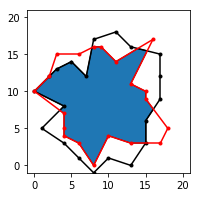

In [15]:
solutions.test_overlaying(overlaying)

result=POLYGON ((5.775280898876405 2.910112359550562, 6 1, 2.923076923076923 1.769230769230769, 5.775280898876405 2.910112359550562))


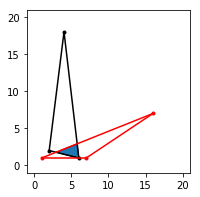

In [13]:
p1=[[2, 2], [4, 18], [6, 1]]
p2=[[1, 1], [16, 7], [7, 1]]

solutions.show_test(p1,p2)